In [1]:
%reload_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from alphabase.spectral_library.base import SpecLibBase
from alphadia.transferlearning.train import *


In [2]:
import torch
torch.set_num_threads(10)

In [2]:
transfer_lib = SpecLibBase()
transfer_lib.load_hdf('C:/Users/USER/Desktop/Germany/work/MPIB/alphaDia/second_pass_score/second_pass_score/output/speclib.transfer.hdf', load_mod_seq=True)

In [4]:
transfer_lib = SpecLibBase()
transfer_lib.load_hdf('C:/Users/USER/Desktop/Germany/work/MPIB/alphaDia/d0_search/output/speclib.transfer.hdf', load_mod_seq=True)

In [3]:
transfer_lib = SpecLibBase()
transfer_lib.load_hdf('C:/Users/USER/Desktop/Germany/work/MPIB/alphaDia/speclib.transfer.hdf', load_mod_seq=True)
transfer_lib.precursor_df.head()

,charge,frag_start_idx,frag_stop_idx,mobility,mod_seq_charge_hash,mod_seq_hash,nAA,precursor_mz,rt,genes,...,mz_observed,precursor_idx,proba,proteins,rt_calibrated,rt_library,rt_norm,rt_observed,sequence,use_for_ms2
0,2,0,6,0.000001,16567173003293321201,16567173003293321199,7,450.281660,788.07110,SKIL_HUMAN,...,450.28150,863296,0.048353,P12757,973.81915,1155.54150,0.345942,788.07110,ILEEVLR,True
1,2,6,12,0.000001,4618820694754887703,4618820694754887701,7,397.753404,423.29166,SHSA4_HUMAN,...,397.75214,216536,0.125965,Q96DD7,424.34580,740.40420,0.217576,423.29166,PPAGLRR,False
2,2,12,18,0.000001,14815979281979287173,14815979281979287171,7,385.213778,403.07294,PIRC1_HUMAN,...,385.21380,216104,0.124993,Q5BN46,451.63693,715.64435,0.192627,403.07294,ATAPPER,False
3,2,18,24,0.000001,16519725553471297779,16519725553471297777,7,443.273835,401.38837,TRM44_HUMAN,...,443.27356,782703,0.125095,Q8IYL2,486.54074,690.53510,0.177122,401.38837,TKQPEAK,False
4,2,24,30,0.000001,3187609901239812214,3187609901239812212,7,391.213778,320.52686,MTX1_HUMAN,...,391.21393,821815,0.125102,Q13505,423.20860,741.59850,0.164096,320.52686,PPSPEAR,False


## RT Fine-tuning


2024-05-19 00:52:54> Predicting RT ...


100%|██████████| 29/29 [00:14<00:00,  2.02it/s]


Text(0, 0.5, 'RT predicted')

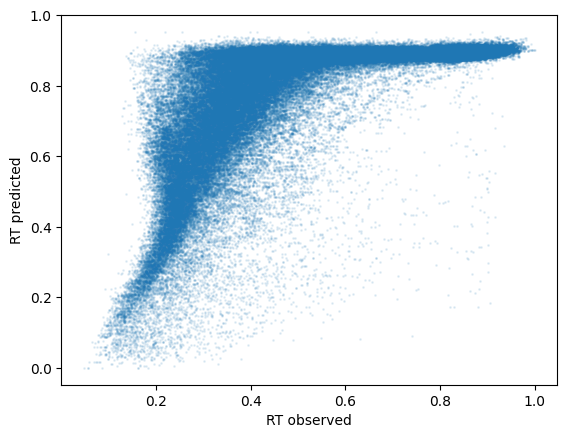

In [4]:

tune_mgr = FinetuneManager(
    device="gpu",
    settings=settings)
tune_mgr.nce = 25
tune_mgr.instrument = 'Lumos'
transfer_lib.precursor_df = tune_mgr.predict_rt(transfer_lib.precursor_df)
plt.scatter(transfer_lib.precursor_df['rt_norm'], transfer_lib.precursor_df['rt_norm_pred'], s=1, alpha=0.1)
plt.xlabel('RT observed')
plt.ylabel('RT predicted')

2024-05-19 01:07:14>  Epoch -1  Lr: 0.00000   Training loss: 0.0000   Test loss: 0.2368
2024-05-19 01:07:14>  Fine-tuning RT model
2024-05-19 01:07:17>  Epoch 0   Lr: 0.00010   Training loss: 0.1624   Test loss: 0.1288
2024-05-19 01:07:20>  Epoch 1   Lr: 0.00020   Training loss: 0.0817   Test loss: 0.0519
2024-05-19 01:07:22>  Epoch 2   Lr: 0.00030   Training loss: 0.0353   Test loss: 0.0298
2024-05-19 01:07:24>  Epoch 3   Lr: 0.00040   Training loss: 0.0256   Test loss: 0.0247
2024-05-19 01:07:27>  Epoch 4   Lr: 0.00050   Training loss: 0.0220   Test loss: 0.0212
2024-05-19 01:07:29>  Epoch 5   Lr: 0.00050   Training loss: 0.0192   Test loss: 0.0197
2024-05-19 01:07:32>  Epoch 6   Lr: 0.00050   Training loss: 0.0174   Test loss: 0.0184
2024-05-19 01:07:34>  Epoch 7   Lr: 0.00050   Training loss: 0.0158   Test loss: 0.0163
2024-05-19 01:07:36>  Epoch 8   Lr: 0.00050   Training loss: 0.0146   Test loss: 0.0152
2024-05-19 01:07:38>  Epoch 9   Lr: 0.00050   Training loss: 0.0140   Test lo

100%|██████████| 29/29 [00:01<00:00, 15.31it/s]


Text(0, 0.5, 'RT predicted')

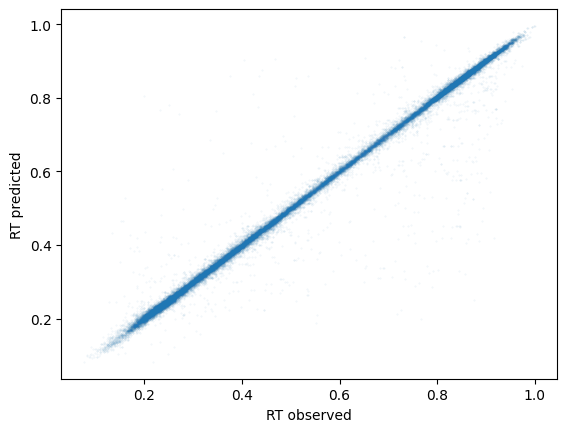

In [11]:
stats = tune_mgr.finetune_rt(transfer_lib.precursor_df)

transfer_lib.precursor_df = tune_mgr.predict_rt(transfer_lib.precursor_df)

plt.scatter(transfer_lib.precursor_df['rt_norm'], transfer_lib.precursor_df['rt_norm_pred'], s=0.1, alpha=0.1)
plt.xlabel('RT observed')
plt.ylabel('RT predicted')


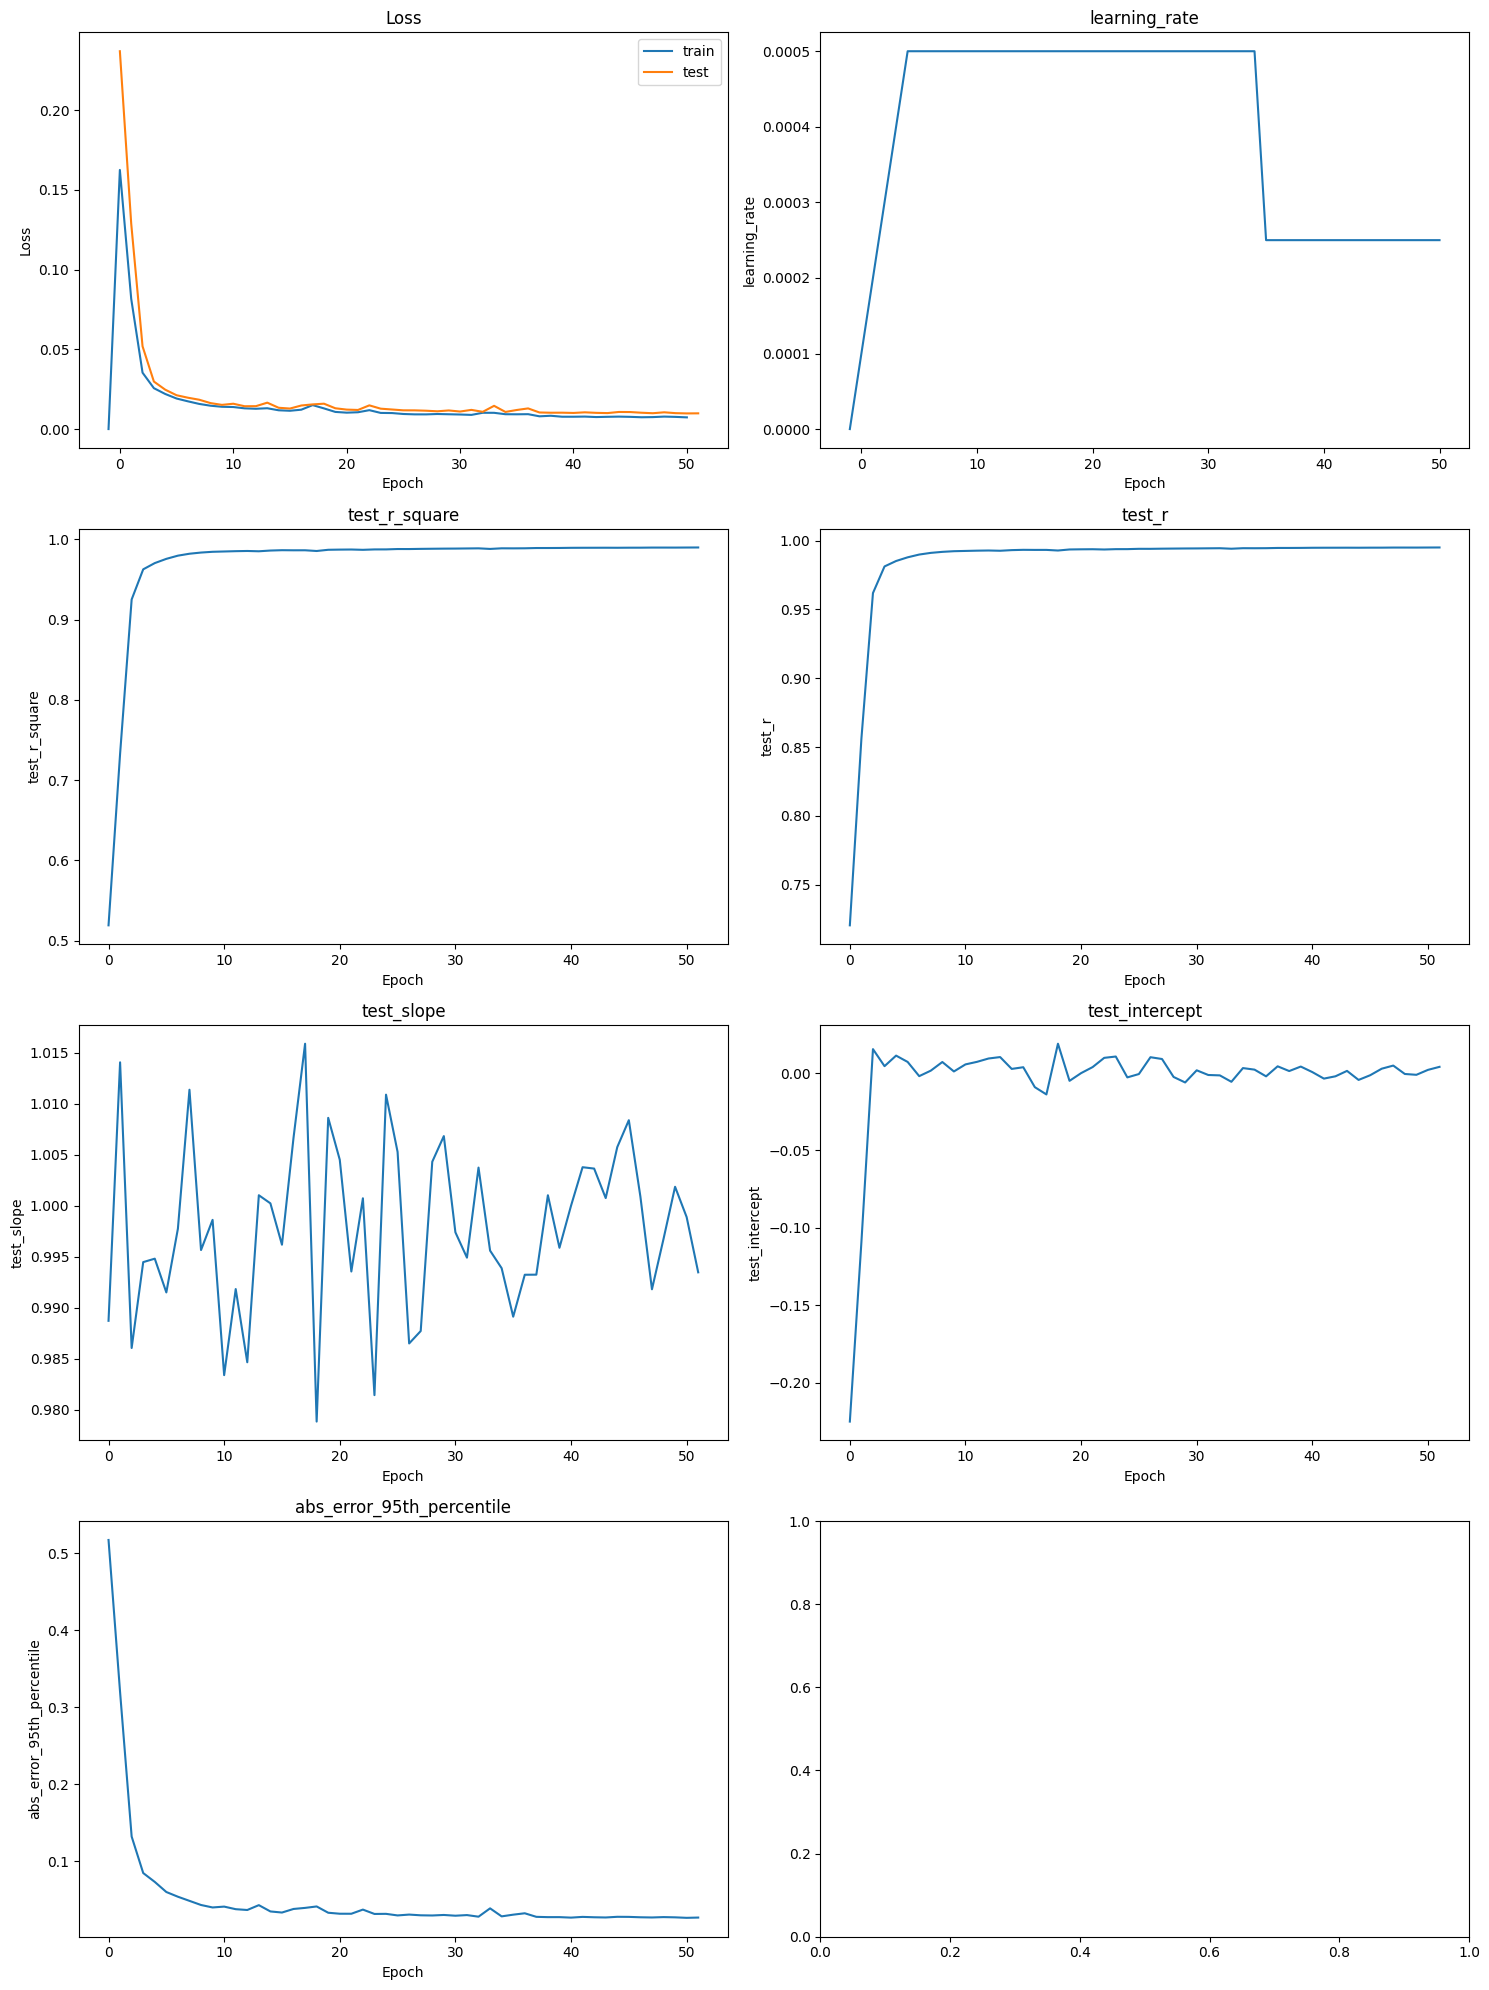

In [12]:

num_plots = len(stats.columns) - 3
fig_col = 2
fig_row = np.ceil(num_plots / fig_col).astype(int) + 1
fig, ax = plt.subplots(fig_row, fig_col, figsize=(15, 5 * fig_row))

x_axis = stats["epoch"]
# Train and test loss
ax[0, 0].plot(x_axis, stats["train_loss"], label="train")
ax[0, 0].plot(x_axis, stats["test_loss"], label="test")
ax[0, 0].set_title("Loss")
ax[0, 0].set_xlabel("Epoch")
ax[0, 0].set_ylabel("Loss")
ax[0, 0].legend()


# Rest of the columns
columns_to_plot = stats.columns.drop(["epoch", "train_loss", "test_loss"])
for i, column_name in enumerate(columns_to_plot):
    row = (i + 1) // fig_col
    col = (i + 1) % fig_col
    ax[row, col].plot(x_axis, stats[column_name])
    ax[row, col].set_title(column_name)
    ax[row, col].set_xlabel("Epoch")
    ax[row, col].set_ylabel(column_name)


plt.tight_layout()
plt.show()

## Charge Fine-tuning

In [13]:

# Testing the charge finetuning on the transfer library
stats = tune_mgr.finetune_charge(psm_df=transfer_lib.precursor_df)

2024-05-19 01:09:47>  Epoch -1  Lr: 0.00000   Training loss: 0.0000   Test loss: 0.7637
2024-05-19 01:09:47>  Fine-tuning Charge model
2024-05-19 01:09:52>  Epoch 0   Lr: 0.00010   Training loss: 0.5770   Test loss: 0.8673
2024-05-19 01:09:56>  Epoch 1   Lr: 0.00020   Training loss: 0.4569   Test loss: 0.6282
2024-05-19 01:10:01>  Epoch 2   Lr: 0.00030   Training loss: 0.3755   Test loss: 0.5428
2024-05-19 01:10:06>  Epoch 3   Lr: 0.00040   Training loss: 0.3325   Test loss: 0.4733
2024-05-19 01:10:10>  Epoch 4   Lr: 0.00050   Training loss: 0.3489   Test loss: 0.3662
2024-05-19 01:10:15>  Epoch 5   Lr: 0.00050   Training loss: 0.3225   Test loss: 0.5290
2024-05-19 01:10:19>  Epoch 6   Lr: 0.00050   Training loss: 0.2960   Test loss: 0.4352
2024-05-19 01:10:24>  Epoch 7   Lr: 0.00050   Training loss: 0.2799   Test loss: 0.3725
2024-05-19 01:10:28>  Epoch 8   Lr: 0.00050   Training loss: 0.2609   Test loss: 0.3425
2024-05-19 01:10:32>  Epoch 9   Lr: 0.00050   Training loss: 0.2531   Tes

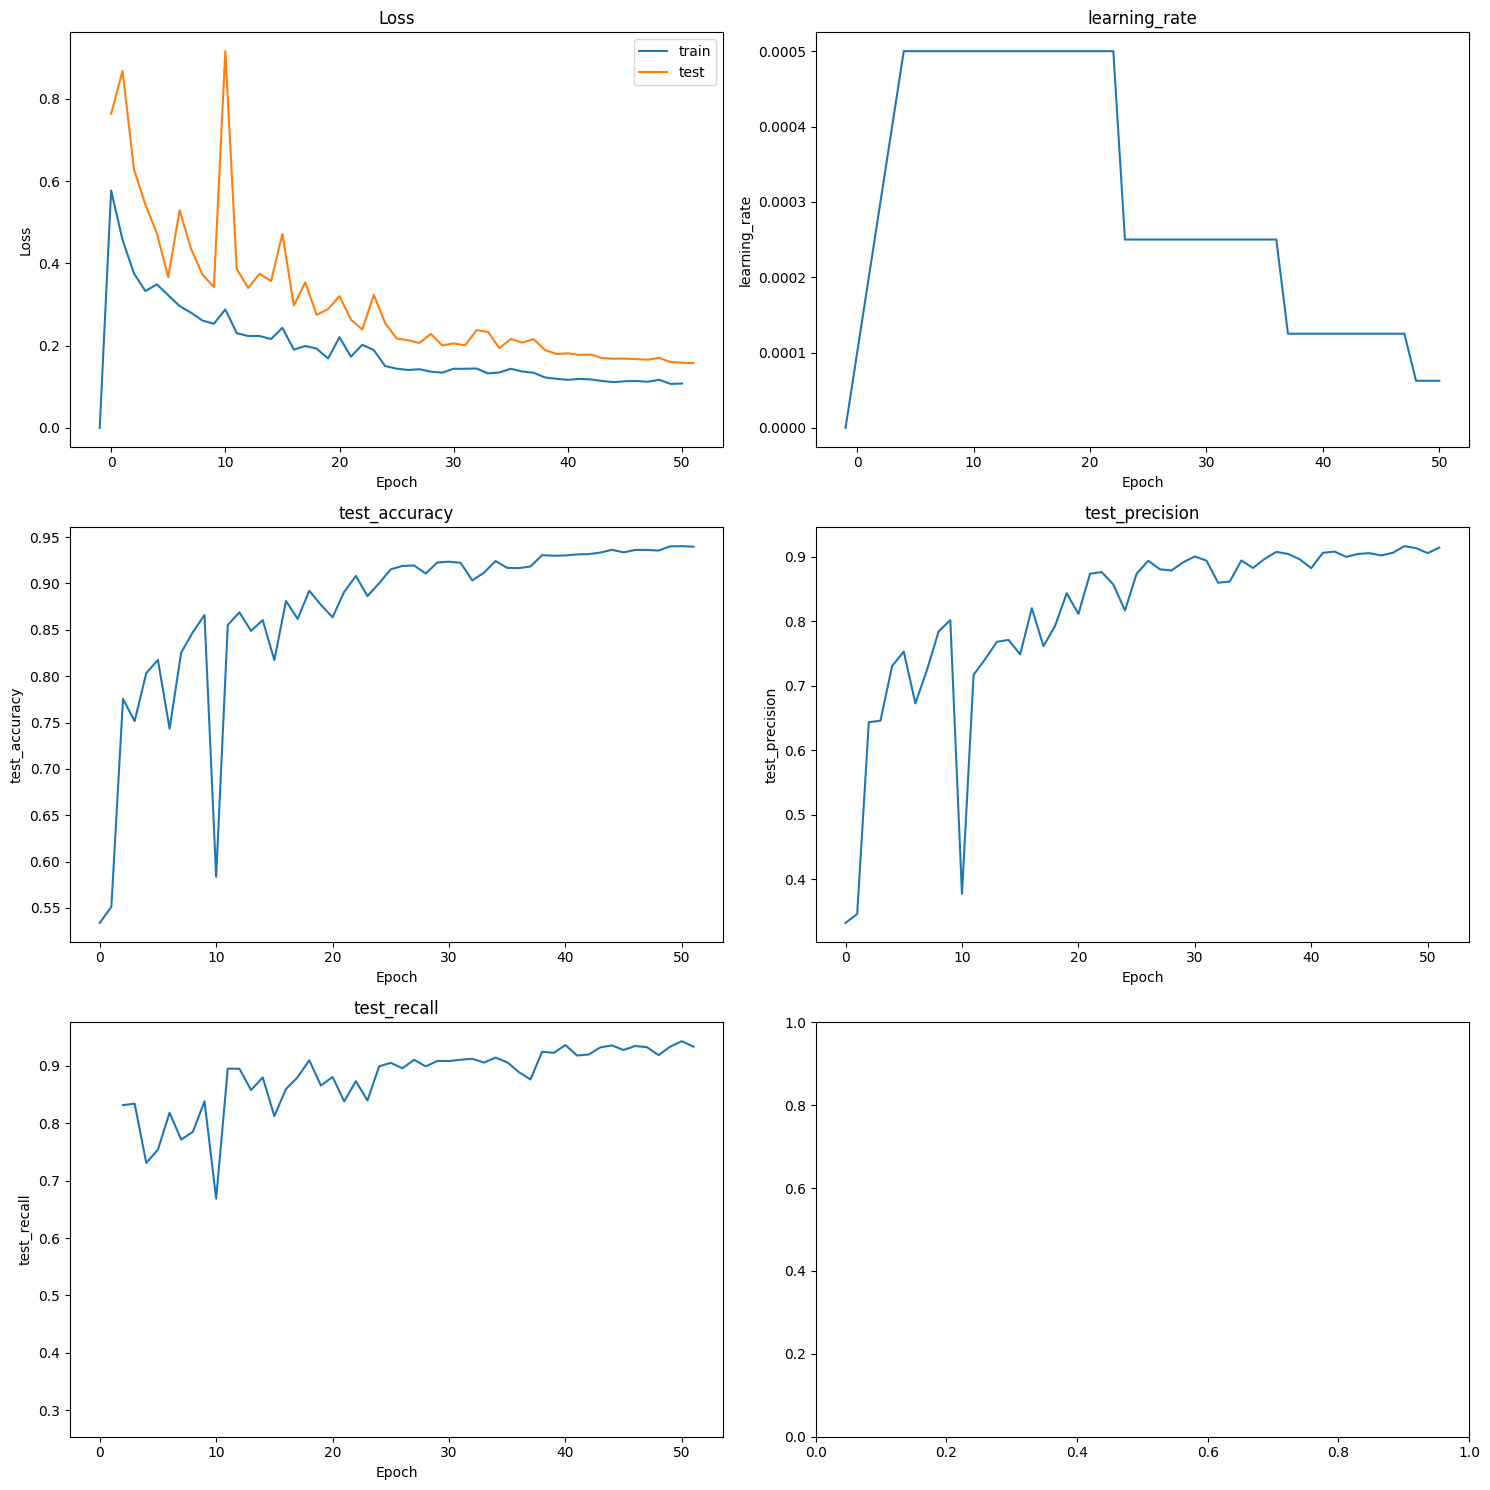

In [14]:

num_plots = len(stats.columns) - 3
fig_col = 2
fig_row = np.ceil(num_plots / fig_col).astype(int) + 1
fig, ax = plt.subplots(fig_row, fig_col, figsize=(15, 5 * fig_row))

x_axis = stats["epoch"]
# Train and test loss
ax[0, 0].plot(x_axis, stats["train_loss"], label="train")
ax[0, 0].plot(x_axis, stats["test_loss"], label="test")
ax[0, 0].set_title("Loss")
ax[0, 0].set_xlabel("Epoch")
ax[0, 0].set_ylabel("Loss")
ax[0, 0].legend()

# Rest of the columns
columns_to_plot = stats.columns.drop(["epoch", "train_loss", "test_loss"])
for i, column_name in enumerate(columns_to_plot):
    row = (i + 1) // fig_col
    col = (i + 1) % fig_col
    ax[row, col].plot(x_axis, stats[column_name])
    ax[row, col].set_title(column_name)
    ax[row, col].set_xlabel("Epoch")
    ax[row, col].set_ylabel(column_name)


plt.tight_layout()
plt.show()

## MS2 Fine-tuning

In [5]:

transfer_lib.precursor_df = transfer_lib.precursor_df[transfer_lib.precursor_df['use_for_ms2']]


In [6]:
def calculate_similarity(precursor_df_a, precursor_df_b, intensity_df_a, intensity_df_b):

    _a_df = precursor_df_a[['precursor_idx', 'frag_start_idx', 'frag_stop_idx']].copy()
    _b_df = precursor_df_b[['precursor_idx', 'frag_start_idx', 'frag_stop_idx']].copy()

    _merged_df = pd.merge(_a_df, _b_df, on='precursor_idx', suffixes=('_a', '_b'))
    # keep only first precursor
    _merged_df = _merged_df.drop_duplicates(subset='precursor_idx', keep='first')
    similarity_list = []

    for i, (start_a, stop_a, start_b, stop_b) in enumerate(zip(_merged_df['frag_start_idx_a'], _merged_df['frag_stop_idx_a'], _merged_df['frag_start_idx_b'], _merged_df['frag_stop_idx_b'])):
        observed_intensity = intensity_df_a.iloc[start_a:stop_a, :4].values.flatten()
        predicted_intensity = intensity_df_b.iloc[start_b:stop_b, :4].values.flatten()

        similarity = np.dot(observed_intensity, predicted_intensity) / (np.linalg.norm(observed_intensity) * np.linalg.norm(predicted_intensity))
        similarity_list.append({'similarity': similarity, 'index': i, 'precursor_idx': _merged_df.iloc[i]['precursor_idx']})

    return pd.DataFrame(similarity_list)

2024-05-19 00:53:32> Predicting MS2 ...


100%|██████████| 29/29 [00:04<00:00,  6.99it/s]


0.6474876272674746


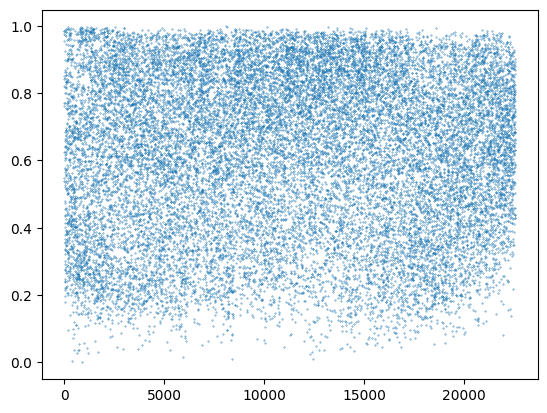

In [7]:
res = tune_mgr.predict_all(transfer_lib.precursor_df.copy(), predict_items=['ms2'])

precursor_after_df = res['precursor_df']
fragment_mz_after_df = res['fragment_mz_df']
fragment_intensity_after_df = res['fragment_intensity_df']
similarity_after_df = calculate_similarity(precursor_after_df, transfer_lib.precursor_df, fragment_intensity_after_df, transfer_lib.fragment_intensity_df)
print(similarity_after_df['similarity'].median())
plt.scatter(similarity_after_df['index'], similarity_after_df['similarity'], s=0.1)

In [8]:

# Testing the ms2 finetuning on the transfer library
stats = tune_mgr.finetune_ms2(psm_df=transfer_lib.precursor_df.copy(), matched_intensity_df=transfer_lib.fragment_intensity_df.copy())

100%|██████████| 9086/9086 [00:05<00:00, 1596.03it/s]


2024-05-19 00:53:57>  Epoch -1  Lr: 0.00000   Training loss: 0.0000   Test loss: 0.0412
2024-05-19 00:53:57>  Fine-tuning MS2 model
2024-05-19 00:53:57> Training with fixed sequence length: 0
[Training] Epoch=1, lr=0.0001, loss=0.028687741698733733
2024-05-19 00:54:05>  Epoch 0   Lr: 0.00010   Training loss: 0.0287   Test loss: 0.0251
[Training] Epoch=2, lr=0.0002, loss=0.021219893102990647
2024-05-19 00:54:14>  Epoch 1   Lr: 0.00020   Training loss: 0.0212   Test loss: 0.0190
[Training] Epoch=3, lr=0.0003, loss=0.020697387793630947
2024-05-19 00:54:22>  Epoch 2   Lr: 0.00030   Training loss: 0.0207   Test loss: 0.0194
[Training] Epoch=4, lr=0.0004, loss=0.019227383384371504
2024-05-19 00:54:31>  Epoch 3   Lr: 0.00040   Training loss: 0.0192   Test loss: 0.0185
[Training] Epoch=5, lr=0.0005, loss=0.019070378961224183
2024-05-19 00:54:39>  Epoch 4   Lr: 0.00050   Training loss: 0.0191   Test loss: 0.0178
[Training] Epoch=6, lr=0.0005, loss=0.019188909024438438
2024-05-19 00:54:49>  Epoc

2024-05-19 01:01:57> Predicting MS2 ...


100%|██████████| 29/29 [00:03<00:00,  7.58it/s]


0.9708472906797629


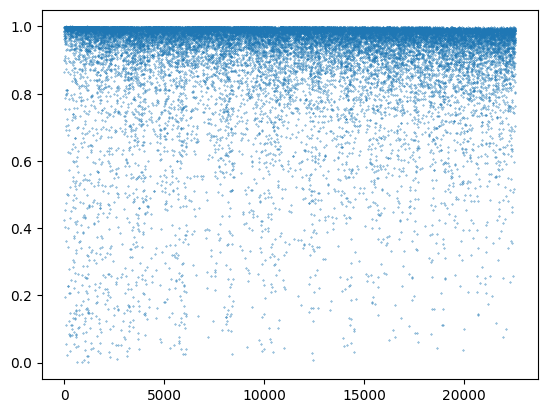

In [9]:
res = tune_mgr.predict_all(transfer_lib.precursor_df.copy(), predict_items=['ms2'])

precursor_after_df = res['precursor_df']
fragment_mz_after_df = res['fragment_mz_df']
fragment_intensity_after_df = res['fragment_intensity_df']
similarity_after_df = calculate_similarity(precursor_after_df, transfer_lib.precursor_df, fragment_intensity_after_df, transfer_lib.fragment_intensity_df)
print(similarity_after_df['similarity'].median())
plt.scatter(similarity_after_df['index'], similarity_after_df['similarity'], s=0.1)

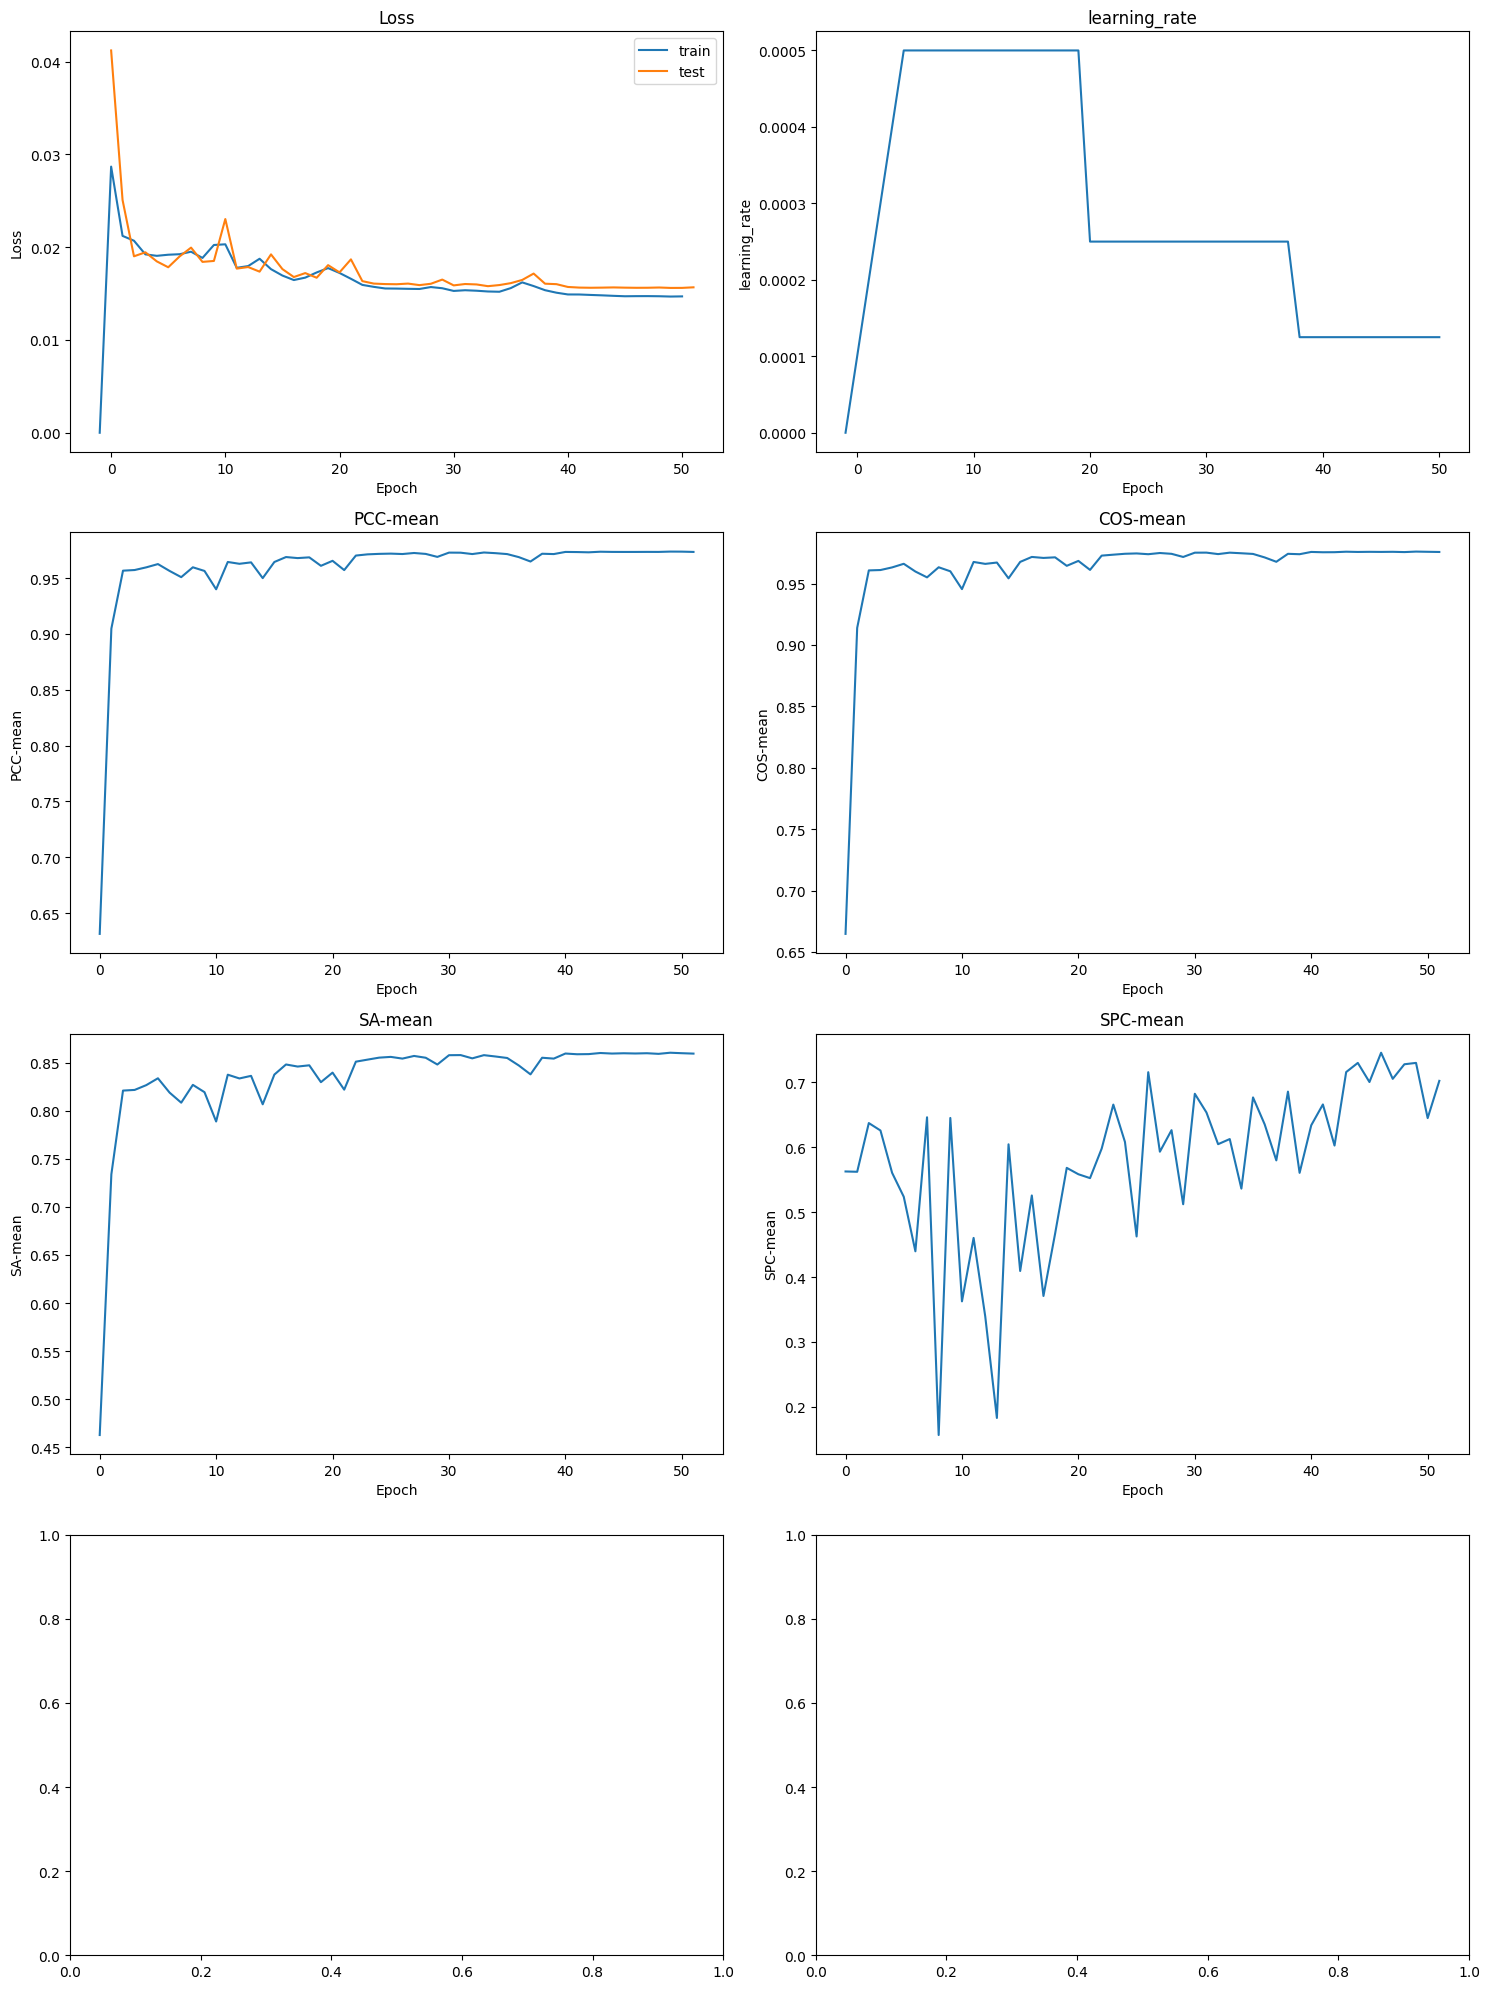

In [10]:

num_plots = len(stats.columns) - 3
fig_col = 2
fig_row = np.ceil(num_plots / fig_col).astype(int) + 1
fig, ax = plt.subplots(fig_row, fig_col, figsize=(15, 5 * fig_row))

x_axis = stats["epoch"]
# Train and test loss
ax[0, 0].plot(x_axis, stats["train_loss"], label="train")
ax[0, 0].plot(x_axis, stats["test_loss"], label="test")
ax[0, 0].set_title("Loss")
ax[0, 0].set_xlabel("Epoch")
ax[0, 0].set_ylabel("Loss")
ax[0, 0].legend()


# Rest of the columns
columns_to_plot = stats.columns.drop(["epoch", "train_loss", "test_loss"])
for i, column_name in enumerate(columns_to_plot):
    row = (i + 1) // fig_col
    col = (i + 1) % fig_col
    ax[row, col].plot(x_axis, stats[column_name])
    ax[row, col].set_title(column_name)
    ax[row, col].set_xlabel("Epoch")
    ax[row, col].set_ylabel(column_name)


plt.tight_layout()
plt.show()